In [1]:
# GAN
from lightweight_gan.lightweight_gan import Trainer
import torch
from torch import nn
# import torchvision
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
# from datetime import datetime
from PIL import Image

# regression
# import math
# import datetime
# from pathlib import Path
from tqdm import tqdm
import time
import pickle

# import numpy as np
import pandas as pd
# from PIL import Image
# import torch
# import torch.nn as nn
import torch.nn.functional as F
from torchvision import models#, transforms
# from sklearn.metrics import mean_squared_error as MSE
# from sklearn.metrics import r2_score as r2

import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
import random

import bisect


# import poolformer
# from timm.data import create_transform
# from timm.models import load_checkpoint
import evaluation
import prediction_model

# %matplotlib inline
# from ipywidgets import interact, interactive, interact_manual

import datetime

dt_now = datetime.datetime.now()
date = dt_now.strftime('%Y%m%d')[2:]

Iem_min = 0.
Iem_max = 150.
Iem_interval = 5.
Iem_range = np.arange(Iem_min, Iem_max, Iem_interval)
Vdc_min = 300.
Vdc_max = 1000.
Vdc_interval = 50.
Vdc_range = np.arange(Vdc_min, Vdc_max, Vdc_interval)

### initial setting

In [2]:
base_dir_model = 'D:\\program\\github\\MotorDesignAI\\'
params = {
    'path_regression_motorparameter': f'{base_dir_model}models\\regression\\regressor_motor_parameter.pt',
    # 'path_regression_ironloss': f'{base_dir_model}models\\regression\\regressor_ironloss.pt',
    # 'path_regression_ironloss_params': f'{base_dir_model}models\\regression\\regressor_ironloss_best_params.pkl',
    # 'path_poolformer': f'{base_dir_model}models\\regression\\poolformer_s12.pth.tar',
    'path_generator': f'{base_dir_model}models\\generator\\GAN_2D-V-Nabla.pt',
    'use_cpu': True,
    'path_regression_motorlabel': f'{base_dir_model}models\\data',
    'cnames_label': ['label_Psi_a_coef', 'label_Ld_coef', 'label_Lq_coef'],
    'path_param_scaling': f'{base_dir_model}models\\data\\scaling_params_condition.csv',
    'path_load_folder': 'output',
    'ext': 'png',
}

params_prediction = {
    'Ie_max': 134,
    'Vdc': 650,
    'Ra': 0.1285,
    'Pn': 4,
}

In [3]:
params['modelname'] = 'swin_t'
# params['modelname'] = 'vgg19_bn'
params['typename'] = 'normal'

base_dir = 'results'
res_dir = list(Path('results/wo_optuna2').glob('*'))
res_dir = [str(s)[8:] for s in res_dir]
if params['modelname'] == 'swin_t':
    res = res_dir[10]
    trained_model = 'model_100_6.pt'
elif params['modelname'] == 'vgg19_bn':
    res = res_dir[15]
    trained_model = 'model_100_3.pt'
else:
    raise NameError

res = Path(res)
params['path_regression_ironloss'] = base_dir / res / trained_model
params['path_regression_ironloss_params'] = f'{base_dir}\\{res}\\params.pkl'
# params['pathmodel'] = 

In [4]:
trainer = Trainer(
    image_size = 256,
    optimizer = 'adam',
    fmap_max = 512,
    transparent = False,
    greyscale = False,
    batch_size = 10,
    gradient_accumulate_every = 4,
#     load_every = 1000,
    evaluate_every = 1000,
    attn_res_layers = [32],
    disc_output_size = 1,
    antialias = False,
    trunc_psi = 0.75,
    aug_prob = None,
    aug_types = ['cutout', 'translation'],
    dataset_aug_prob = 0.,
    calculate_fid_every = None,
    amp = False
)
trainer.init_GAN()
GAN = trainer.GAN
GAN.load_state_dict(torch.load(params['path_generator'])['GAN'])

<All keys matched successfully>

In [5]:
class RegressionMotorParameter(nn.Module):
    def __init__(self, output_dim1, output_dim2, output_dim3):
        super().__init__()
        self.model_ft = models.resnet18()
        num_ftrs = 1000
        # heads
        self.out1 = nn.Linear(num_ftrs, output_dim1)
        nn.init.xavier_normal_(self.out1.weight)
        self.out2 = nn.Linear(num_ftrs, output_dim2)
        nn.init.xavier_normal_(self.out2.weight)
        self.out3 = nn.Linear(num_ftrs, output_dim3)
        nn.init.xavier_normal_(self.out3.weight)
    def forward(self, x):
        h = self.model_ft(x)
        y1 = self.out1(h)
        y2 = self.out2(h)
        y3 = self.out3(h)
        return y1, y2, y3

In [6]:
# class RegressionIronLoss(nn.Module):
#     def __init__(
#             self,
#             current_dim=2,
#             speed_dim=1,
#             hidden_dim1=50,
#             hidden_dim2=50,
#             output_dim1=1,
#             output_dim2=1,
#             weight_id=1.0,
#             weight_iq=1.0,
#             weight_speed=1.0,
#             learning_type='transfer_learning',
#             activation_type='ReLU',
#             device='cpu',
#             **kwargs,
#         ):
#         super().__init__()
#         ## image
#         self.model_ft = poolformer.poolformer_s12()
#         if learning_type=='transfer_learning':
#             load_checkpoint(model=self.model_ft, checkpoint_path=params['path_poolformer'])
#             for param in self.model_ft.parameters():
#                 param.requires_grad = False
#         elif learning_type=='fine_tuning':
#             load_checkpoint(model=self.model_ft, checkpoint_path=params['path_poolformer'])
#         elif learning_type=='normal':
#             pass
#         else:
#             raise NotImplementedError(f'learning type "{learning_type}" is unknown')
#         num_ftrs = 1000
#         self.hidden1 = nn.Linear(num_ftrs, hidden_dim1)
#         self.bn1 = nn.BatchNorm1d(hidden_dim1)
#         self.hidden2 = nn.Linear(hidden_dim1+current_dim+speed_dim, hidden_dim2)
#         self.bn2 = nn.BatchNorm1d(hidden_dim2)
#         self.out1 = nn.Linear(hidden_dim2, output_dim1)
#         self.out2 = nn.Linear(hidden_dim2, output_dim2)

#         if activation_type=='ReLU':
#             self.activation = F.relu
#         elif activation_type=='ELU':
#             self.activation = F.elu
#         else:
#             raise NotImplementedError(f'activation type "{activation_type}" is unknown')

#         self.weights = torch.tensor([
#             weight_id,
#             weight_iq,
#             weight_speed,
#         ]).to(device)

#     def forward(self, image, current, speed): # current: 2-dim
#         ## image
#         x1 = self.model_ft(image)
#         x1 = self.hidden1(x1)
#         x1 = self.bn1(x1)
#         x1 = self.activation(x1)
#         ## concatenation
#         x = torch.cat([x1,current*self.weights[:2]], axis=1)
#         x = torch.cat([x,speed*self.weights[2]], axis=1)
#         x = self.hidden2(x)
#         x = self.bn2(x)
#         x = self.activation(x)
#         y1 = self.out1(x)
#         y2 = self.out2(x)
#         return y1, y2

class RegressionIronLoss(nn.Module):
    def __init__(
            self,
            current_dim=2,
            speed_dim=1,
            hidden_dim_init=6,
            num_hidden_dims=3,
            hidden_dim_out=50,
            hidden_dim_other=25,
            num_hidden_dims2=5,
            hidden_dim_out2=50,
            hidden_dim_other2=35,
            output_dim1=1,
            output_dim2=1,
            # weight_id=1.0,
            # weight_iq=1.0,
            # weight_speed=1.0,
            # learning_type='transfer_learning',
            activation_type='ReLU',
            modelname=None, 
            typename=None, 
            pathmodel=None,
            **kwargs,
        ):
        super().__init__()
        ## init
        self.model_ft = prediction_model.model(modelname, typename, pathmodel)
        num_ftrs = 1000
        self.linear1 = nn.Linear(num_ftrs, hidden_dim_init)
        self.bn1 = nn.BatchNorm1d(hidden_dim_init)
        ## joule
        hidden_dims = [hidden_dim_other]*num_hidden_dims
        hidden_dims[-1] = hidden_dim_out
        linear_list1 = []
        batch_norm_list1 = []
        hidden_dim_before = hidden_dim_init+current_dim+speed_dim
        for hidden_dim in hidden_dims:
            linear_list1.append(nn.Linear(hidden_dim_before, hidden_dim))
            batch_norm_list1.append(nn.BatchNorm1d(hidden_dim))
            hidden_dim_before = hidden_dim
        self.linear_list1 = nn.ModuleList(linear_list1)
        self.batch_norm_list1 = nn.ModuleList(batch_norm_list1)
        self.out1 = nn.Linear(hidden_dim_before, output_dim1)
        ## hysteresis
        hidden_dims2 = [hidden_dim_other2]*num_hidden_dims2
        hidden_dims2[-1] = hidden_dim_out2
        linear_list2 = []
        batch_norm_list2 = []
        hidden_dim_before = hidden_dim_init+current_dim+speed_dim
        for hidden_dim in hidden_dims2:
            linear_list2.append(nn.Linear(hidden_dim_before, hidden_dim))
            batch_norm_list2.append(nn.BatchNorm1d(hidden_dim))
            hidden_dim_before = hidden_dim
        self.linear_list2 = nn.ModuleList(linear_list2)
        self.batch_norm_list2 = nn.ModuleList(batch_norm_list2)
        self.out2 = nn.Linear(hidden_dim_before, output_dim2)
        ## activation
        if activation_type=='ReLU':
            self.activation = F.relu
        elif activation_type=='ELU':
            self.activation = F.elu
        else:
            raise NotImplementedError(f'activation type "{activation_type}" is unknown')

    def forward(self, image, current, speed): # current: 2-dim
        ## image
        x = self.model_ft(image)
        x = self.linear1(x)
        x = self.bn1(x)
        x = self.activation(x)
        x = torch.cat([x,current], axis=1)
        x = torch.cat([x,speed], axis=1)
        for i, (f, bn) in enumerate(zip(self.linear_list1, self.batch_norm_list1)):
            x1 = f(x1) if i > 0 else f(x)
            x1 = bn(x1)
            x1 = self.activation(x1)
        for i, (f, bn) in enumerate(zip(self.linear_list2, self.batch_norm_list2)):
            x2 = f(x2) if i > 0 else f(x)
            x2 = bn(x2)
            x2 = self.activation(x2)
        y1 = self.out1(x1)
        y2 = self.out2(x2)
        return y1, y2

In [7]:
# use_cpu = params['use_cpu']
# device = torch.device('cuda' if not use_cpu else 'cpu')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
regression_model_motorparameter = RegressionMotorParameter(4,10,15).to(device)
# regression_model_motorparameter.load_state_dict(torch.load(params['path_regression_motorparameter']))
regression_model_motorparameter.load_state_dict(torch.load(params['path_regression_motorparameter'], map_location=torch.device(device)))

folder_label = Path(params['path_regression_motorlabel'])
cnames_label = params['cnames_label']
sp = [pd.read_csv(
    folder_label / f'{cname}_scaling_parameters.csv',
    index_col=0) for cname in cnames_label]
sp = [sp_.values for sp_ in sp]

with open(params['path_regression_ironloss_params'], "rb") as tf:
    ironloss_params = pickle.load(tf)
ironloss_params['device'] = device
regression_model_ironloss = RegressionIronLoss(**ironloss_params).to(device)
regression_model_ironloss.load_state_dict(torch.load(params['path_regression_ironloss'], map_location=torch.device(device)))
regression_model_ironloss.eval()

param_scaling = pd.read_csv(params['path_param_scaling'], index_col=0)
params_prediction['device'] = device
params_prediction['sp'] = sp
params_prediction['param_scaling'] = param_scaling

In [8]:
evaln = evaluation.Evaluate(
    regression_model_motorparameter=regression_model_motorparameter,
    regression_model_ironloss=regression_model_ironloss,
    **params_prediction)

In [9]:
# plt.rcParams['axes.grid'] = True
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 13

plt.rcParams["mathtext.fontset"] = 'stix'

plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['axes.linewidth'] = 1.0
plt.rcParams['axes.grid'] = True

plt.rcParams['legend.fancybox'] = False
plt.rcParams['legend.framealpha'] = 1
plt.rcParams['legend.edgecolor'] = 'black'

plt.rcParams['axes.grid'] = False
plt.rcParams['xtick.bottom'] = False
plt.rcParams['ytick.left'] = False
plt.rcParams['ytick.right'] = False

# import datetime

# dt_now = datetime.datetime.now()
# date = dt_now.strftime('%Y%m%d')[2:]

In [10]:
import warnings
warnings.resetwarnings()
warnings.simplefilter('ignore', DeprecationWarning)

In [11]:
n_var = GAN.latent_dim
params_optimization = {
    'regression_model_motorparameter': regression_model_motorparameter,
    'regression_model_ironloss': regression_model_ironloss,
    'GAN': GAN,
    'n_var': n_var,
    'xl': np.ones(n_var)*-1000,
    'xu': np.ones(n_var)*1000,
}


In [37]:
params_optimization['pop_size'] = 100
params_optimization['n_offsprings'] = 20
params_optimization['n_termination'] = 50
params_optimization['verbose'] = True


In [13]:
def calc_pareto_front(f):
    f_sorted_by_f1 = f[np.argsort(f[:,0])]    
    pareto_front = [f_sorted_by_f1[0]]
    for pair in f_sorted_by_f1[1:]:
        if pair[1] <= pareto_front[-1][1]:
            pareto_front = np.vstack((pareto_front,pair))
    return pareto_front    

In [14]:
import cv2

def judge_topology(img):
    img_h = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)[:,:,0]
    thre, region_h_min = cv2.threshold(img_h, 200, 1, cv2.THRESH_BINARY_INV)
    thre, region_h_max = cv2.threshold(img_h, 300, 1, cv2.THRESH_BINARY)
    region_pm = (region_h_min==region_h_max).astype(np.uint8)
    contours_pm, _ = cv2.findContours(region_pm, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours_pm = list(filter(lambda x: cv2.contourArea(x) > 100, contours_pm))
    if len(contours_pm) == 1: return 1
    elif len(contours_pm) == 2: return 2
    elif len(contours_pm) == 3: return 3  

In [38]:
class Optimize:
    def __init__(self,):
        pass
    def optimize(self, Ie_max, Vdc, torque1, torque2, efficiency1, efficiency2):
        self.Ie_max = Ie_max
        self.Vdc = Vdc
        self.torque1 = torque1
        self.torque2 = torque2
        self.efficiency1 = efficiency1
        self.efficiency2 = efficiency2
        params_prediction['Ie_max'] = float(Ie_max)
        params_prediction['Vdc'] = float(Vdc)
        required_torque_points = np.array([
            [float(x.strip()) for x in torque1.split(',')], 
            [float(x.strip()) for x in torque2.split(',')],
        ])
        evaluate_efficiency_points = np.array([
            [float(x.strip()) for x in efficiency1.split(',')], 
            [float(x.strip()) for x in efficiency2.split(',')],
        ])
        params_optimization['required_torque_points'] = required_torque_points
        params_optimization['evaluate_efficiency_points'] = evaluate_efficiency_points
        params_optimization['n_obj'] = evaluate_efficiency_points.shape[1]
        params_optimization['n_constr'] = required_torque_points.shape[1]

        opt = evaluation.Optimize(
           params_prediction=params_prediction,
           params_optimization=params_optimization,
        )
        opt.optimize(seed=params_optimization['seed']) #0,3
        # opt.show_best_result()
        self.opt = opt
        
params_optimization['seed'] = 3
f = Optimize()

In [39]:
f.optimize(
    Ie_max='134', Vdc='650', 
    torque1='197, 3000', torque2='40, 11000', 
    efficiency1='20, 3500', efficiency2='20, 11000'
)

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |      100 |      5 |  0.000000E+00 |  0.1101702921 |             - |             -
     2 |      120 |      5 |  0.000000E+00 |  0.0761197873 |  0.000000E+00 |             f
     3 |      140 |      4 |  0.000000E+00 |  0.0583573190 |  0.1574877802 |         ideal
     4 |      160 |      5 |  0.000000E+00 |  0.0449525388 |  0.0603615166 |             f
     5 |      180 |      9 |  0.000000E+00 |  0.0343299905 |  0.0711038429 |             f
     6 |      200 |      9 |  0.000000E+00 |  0.0257642668 |  0.2016958450 |         ideal
     7 |      220 |     10 |  0.000000E+00 |  0.0187305649 |  0.0697269593 |         ideal
     8 |      240 |     12 |  0.000000E+00 |  0.0122920941 |  0.0308615339 |             f
     9 |      260 |     13 |  0.000000E+00 |  0.0080676451 |  0.0236051984 |             f
    10 |      280 |     14 |  0.000000E+00 |  0.0036736766 |  0.0062390853 |         ideal

In [40]:
f_1 = f.opt.result["F"]
x_1 = f.opt.result["X"]
g_1 = f.opt.result["G"]
hv_1 = f.opt.result["HV"]
cond_1 = f.opt.result["COND"]
loss_1 = f.opt.result["LOSS"]
# cond_1 = np.array([[np.array(list(cond_1[j][i][0].values())) for i in range(100)] for j in range(500)])
# loss_1_arr = np.array([[np.array(list(loss_1[j][i][0].values())) for i in range(100)] for j in range(500)])

In [21]:
save_dir = Path('optimization_results')
dt = datetime.datetime.now().strftime('%Y%m%d%H%M%S')[2:]
(save_dir / dt).mkdir(parents=True, exist_ok=True)
np.save(f'{save_dir}\\{dt}\\{dt}_2DVnabla_fitness_2eff_coef.npy', np.array(f_1))
np.save(f'{save_dir}\\{dt}\\{dt}_2DVnabla_xgeom_2eff_coef.npy', np.array(x_1))
np.save(f'{save_dir}\\{dt}\\{dt}_2DVnabla_constraint_2eff_coef.npy', np.array(g_1))
np.save(f'{save_dir}\\{dt}\\{dt}_2DVnabla_hv_2eff_coef.npy', np.array(hv_1))
np.save(f'{save_dir}\\{dt}\\{dt}_2DVnabla_conditions_2eff_coef.npy', np.array(cond_1))
np.save(f'{save_dir}\\{dt}\\{dt}_2DVnabla_losses_2eff_coef.npy', np.array(loss_1))

params_save = params_optimization.copy()
del_list = [
    'regression_model_motorparameter', 'regression_model_ironloss', 'GAN', 'xl', 'xu',]
for d in del_list:
    params_save.pop(d)
with open(f'{save_dir}\\{dt}\\optimization_params.pkl', "wb") as tf:
    pickle.dump(params,tf)

In [39]:
dt = '230210153538'

f_1 = np.load(f'{save_dir}\\{dt}\\{dt}_2DVnabla_fitness_2eff_coef.npy')
x_1 = np.load(f'{save_dir}\\{dt}\\{dt}_2DVnabla_xgeom_2eff_coef.npy')
g_1 = np.load(f'{save_dir}\\{dt}\\{dt}_2DVnabla_constraint_2eff_coef.npy')
hv_1 = np.load(f'{save_dir}\\{dt}\\{dt}_2DVnabla_hv_2eff_coef.npy')
cond_1 = np.load(f'{save_dir}\\{dt}\\{dt}_2DVnabla_conditions_2eff_coef.npy')
loss_1 = np.load(f'{save_dir}\\{dt}\\{dt}_2DVnabla_losses_2eff_coef.npy')

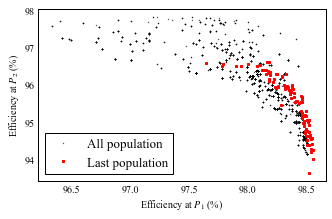

In [22]:
# fig, ax = plt.subplots(figsize=(8/2.54,5/2.54))
fig, ax = plt.subplots(figsize=(12/2.54,8/2.54))

s = np.array(f_1).shape
pf_tmp = calc_pareto_front(np.array(f_1[-1]).reshape(s[1], s[2]))
# ax.plot(pf_tmp[:,0]*14.63, pf_tmp[:,1]*-197, c='c', linewidth=1)
# ax.plot([5,17],[197*1.03,197*1.03],'b--', linewidth=1)
ax.plot(np.array(f_1).reshape(s[0]*s[1], s[2])[:,0]*-100,
         np.array(f_1).reshape(s[0]*s[1], s[2])[:,1]*-100,
         'o', c='k', ms=0.3, label='All population')
ax.plot(np.array(f_1[-1]).reshape(s[1], s[2])[:,0]*-100,
         np.array(f_1[-1]).reshape(s[1], s[2])[:,1]*-100,
         's', c='r', ms=2, label='Last population')
# for i in [0,round(len(pf_tmp)/2),-1]:
#     ax.plot(pf_tmp[i][0]*14.63, pf_tmp[i][1]*-197, 'o', c='g', ms=2)

# pf_tmp = calc_pareto_front(np.array(f_1[-1]).reshape(s[1], s[2]))


# ax.set_yticks(np.arange(120,240+1,40))
# ax.set_yticklabels(np.arange(120,240+1,40))
# ax.set_ylim([120,240])
ax.set_xlabel('Efficiency at $\itP$$_1$ (%)')
ax.set_ylabel('Efficiency at $\itP$$_2$ (%)')

# ax.text(5,197*1.05,'Constraint',color='b')
# ax.text(10,205,'A',color='g')
# ax.text(13,222,'B',color='g')
# ax.text(16.5,227,'C',color='g')

ax.legend(loc='best',fontsize=13)

fig.tight_layout()
plt.savefig(f'{date}_all_population.png', dpi=300, format='png')

IndexError: list index out of range

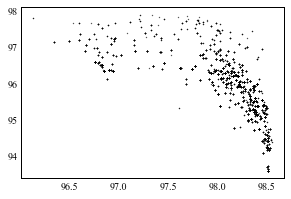

In [22]:
# fig, ax = plt.subplots(figsize=(8/2.54,5/2.54))
fig, ax = plt.subplots(figsize=(12/2.54,8/2.54))

s = np.array(f_1).shape
# pf_tmp = calc_pareto_front(np.array(f_1[50]).reshape(s[1], s[2]))
# ax.plot(pf_tmp[:,0]*14.63, pf_tmp[:,1]*-197, c='c', linewidth=1)
# ax.plot([5,17],[197*1.03,197*1.03],'b--', linewidth=1)
ax.plot(np.array(f_1).reshape(s[0]*s[1], s[2])[:,0]*-100,
         np.array(f_1).reshape(s[0]*s[1], s[2])[:,1]*-100,
         'o', c='k', ms=0.3, label='All population')
ax.plot(np.array(f_1[50]).reshape(s[1], s[2])[:,0]*-100,
         np.array(f_1[50]).reshape(s[1], s[2])[:,1]*-100,
         'o', c='r', ms=2, label='Last population')
ax.plot(np.array(f_1[-1]).reshape(s[1], s[2])[:,0]*-100,
         np.array(f_1[-1]).reshape(s[1], s[2])[:,1]*-100,
         'o', c='b', ms=2, label='Last population')
# for i in [0,round(len(pf_tmp)/2),-1]:
#     ax.plot(pf_tmp[i][0]*14.63, pf_tmp[i][1]*-197, 'o', c='g', ms=2)

# pf_tmp = calc_pareto_front(np.array(f_1[-1]).reshape(s[1], s[2]))


# ax.set_yticks(np.arange(120,240+1,40))
# ax.set_yticklabels(np.arange(120,240+1,40))
# ax.set_ylim([120,240])
# ax.set_xlabel('Permanent magnet volume (area ratio) (%)')
# ax.set_ylabel('Torque at 3000 min$^{-1}$ (Nm)')

# ax.text(5,197*1.05,'Constraint',color='b')
# ax.text(10,205,'A',color='g')
# ax.text(13,222,'B',color='g')
# ax.text(16.5,227,'C',color='g')

# ax.legend(loc='lower right',fontsize=7)

fig.tight_layout()
# plt.savefig(f'{date}_all_population_condition1.png', dpi=300, format='png')

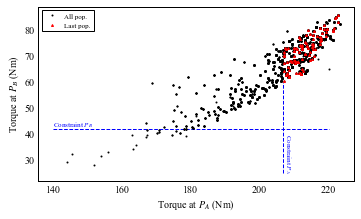

In [29]:
PA = [float(i) for i in f.torque1.split(',')]
PB = [float(i) for i in f.torque2.split(',')]
# fig, ax = plt.subplots(figsize=(8/2.54,5/2.54))
fig, ax = plt.subplots(figsize=(13/2.54,8/2.54))

alpha = 1.05
s = np.array(f_1).shape
pf_tmp = calc_pareto_front(np.array(f_1[-1]).reshape(s[1], s[2]))
# ax.plot(pf_tmp[:,0]*14.63, pf_tmp[:,1]*-197, c='c', linewidth=1)
ax.plot([140,220],[PB[0]*alpha,PB[0]*alpha],'b--', linewidth=1)
ax.plot([PA[0]*alpha,PA[0]*alpha],[25,60],'b--', linewidth=1)
ax.plot((-np.array(g_1)[:,:,0]*PA[0]+PA[0]*alpha).flatten(),
         (-np.array(g_1)[:,:,1]*PA[0]+PB[0]*alpha).flatten(),
         'o', c='k', ms=1, label='All pop.')
ax.plot(-np.array(g_1)[-1,:,0]*PA[0]+PA[0]*alpha,
         -np.array(g_1)[-1,:,1]*PA[0]+PB[0]*alpha,
         '^', c='r', ms=2, label='Last pop.')
# ax.plot(-np.array(g_1)[-1,15,0]*PA[0]+PA[0]*alpha,
#          -np.array(g_1)[-1,15,1]*PA[0]+PB[0]*alpha,
#          's', c='g', ms=5)

# pf_tmp = calc_pareto_front(np.array(f_1[-1]).reshape(s[1], s[2]))


# ax.set_yticks(np.arange(120,240+1,40))
# ax.set_yticklabels(np.arange(120,240+1,40))
# ax.set_ylim([120,240])
ax.set_xlabel('Torque at $\itP$$_A$ (Nm)')
ax.set_ylabel('Torque at $\itP$$_B$ (Nm)')

ax.text(140,40*1.07 ,'Constraint $\itP$$_B$',color='b', fontsize=7)
ax.text(197*1.05,26 ,'Constraint $\itP$$_A$',color='b', rotation=-90, fontsize=7)
# ax.text(10,205,'A',color='g')
# ax.text(13,222,'B',color='g')
# ax.text(16.5,227,'C',color='g')

ax.legend(loc='upper left',fontsize=7)

fig.tight_layout()
# plt.savefig(f'{date}_optimization_result_constraints_NSGA2_2eff1rip_seed2.png', dpi=300, format='png')

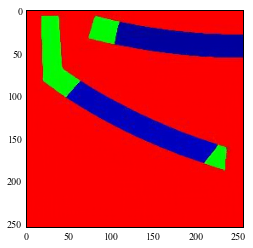

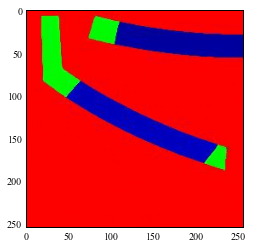

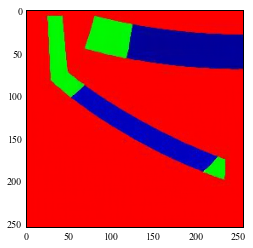

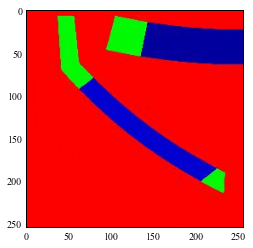

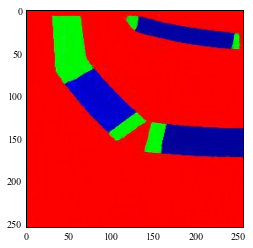

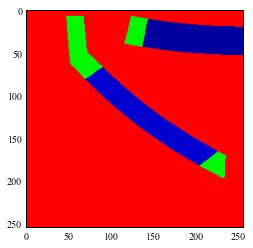

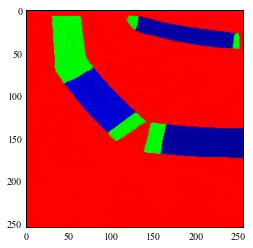

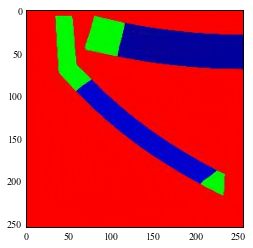

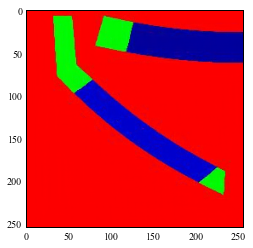

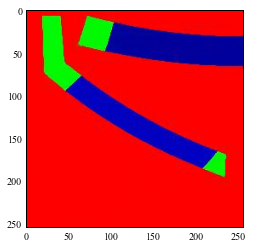

In [30]:
for x in x_1[-1][::10]:
    im = GAN.G(torch.from_numpy(x.reshape(1,-1)).to(device=device, dtype=torch.float) )
    im_np = im.to('cpu').detach().numpy()[0].transpose(1,2,0)
    im_np[im_np>1.]=1.
    im_np[im_np<0.]=0.
    plt.imshow( im_np )
    plt.show()

50


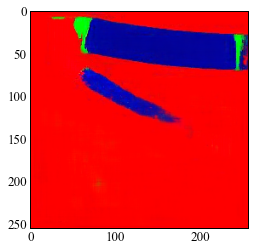

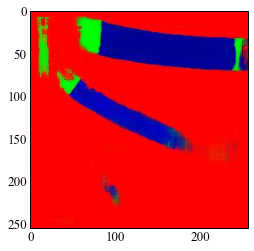

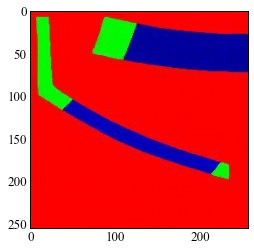

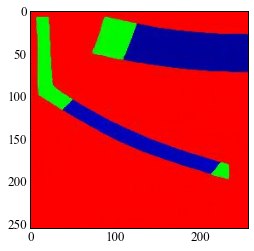

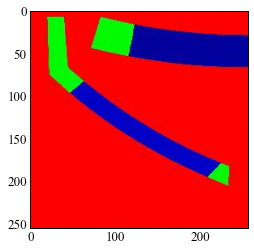

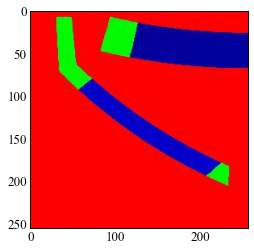

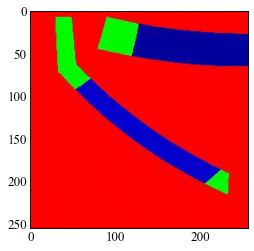

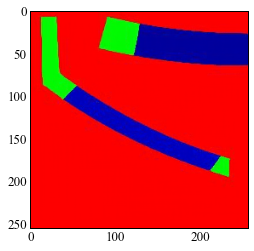

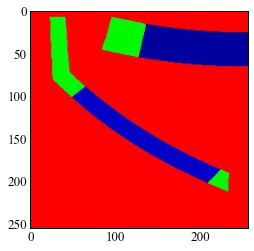

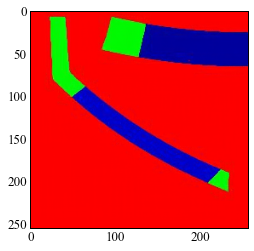

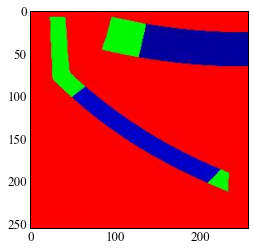

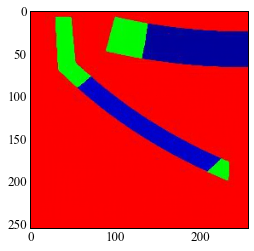

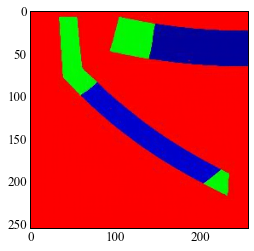

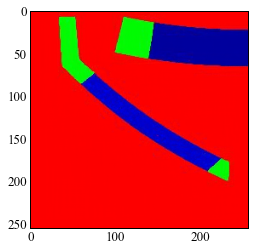

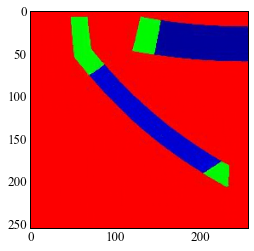

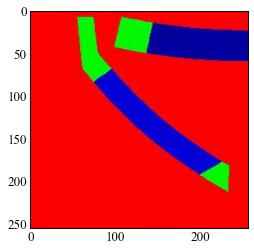

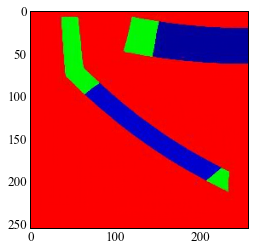

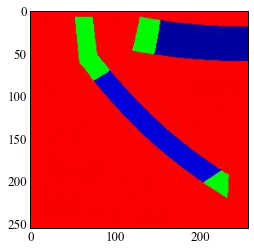

In [41]:
# pf_tmp = calc_pareto_front(np.array(f_1[-1]))
s = np.array(f_1).shape
gen = np.array([50])-1 
modelname = params['modelname']

for n in gen:
    print(n+1)
    pf_tmp = calc_pareto_front(np.array(f_1[n]).reshape(s[1],s[2]))
    pf_tmp_images = []
    pf_tmp_conditions = []
    for i in range(pf_tmp.shape[0]):
        latent_variable = x_1[n][
            np.where(
                np.array(f_1[n])==pf_tmp[pf_tmp[:,1]<-0.5][i][0]
            )[0][0]]
        pf_tmp_conditions.append(cond_1[n][
            np.where(
                np.array(f_1[n])==pf_tmp[pf_tmp[:,1]<-0.5][i][0]
            )[0][0]]
        )
    #     im = generate_truncated(GAN.G, torch.from_numpy(latent_variable.reshape(1,-1)).to(device=device, dtype=torch.float) )
        im = GAN.G(torch.from_numpy(latent_variable.reshape(1,-1)).to(device=device, dtype=torch.float) )
        im_np = im.to('cpu').detach().numpy()[0].transpose(1,2,0)
        im_np[im_np>1.]=1.
        im_np[im_np<0.]=0.
        pf_tmp_images.append(im_np)
        plt.imshow( im_np )
        plt.show()
#     np.save(f'{save_dir}\\{dt}\\{dt}_images_pf_2eff_{modelname}_gen{n}.npy', np.array(pf_tmp_images))
#     np.save(f'{save_dir}\\{dt}\\{dt}_conditions_pf_2eff_{modelname}_gen{n}.npy', np.array(pf_tmp_conditions).transpose(0,2,1))

In [1]:
val_x = np.array(x_1)
shape = val_x.shape
res_topology = np.zeros(shape[:2])
for i in tqdm(range(shape[0])):
    for j in range(shape[1]):
#         latent_variable = calculate_latent_variable(val_x[i,j])
        generated_image = GAN.G(torch.from_numpy(val_x[i,j].reshape(1,-1)).to(device=device, dtype=torch.float) )
        image = generated_image.to('cpu').detach().numpy()[0].transpose(1,2,0)
        res_topology[i,j] = judge_topology(image)
# res_topology

NameError: name 'np' is not defined

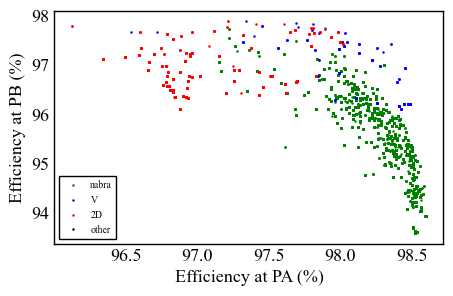

In [66]:
val = np.array(f_1)
val_2D = val[res_topology==3]
val_V = val[res_topology==1]
val_nabra = val[res_topology==2]
val_other = val[np.isnan(res_topology)]

# fig, ax = plt.subplots(figsize=(8/2.54,5/2.54))
fig, ax = plt.subplots(figsize=(12/2.54,8/2.54))

ax.plot(val_nabra.T[0]*-100,val_nabra.T[1]*-100, 'o', c='g', ms=0.8, label='nabra')
ax.plot(val_V.T[0]*-100,val_V.T[1]*-100, 'o', c='b', ms=0.8, label='V')
ax.plot(val_2D.T[0]*-100,val_2D.T[1]*-100, 'o', c='r', ms=0.8, label='2D')
ax.plot(val_other.T[0]*-100,val_other.T[1]*-100, 'o', c='k', ms=0.8, label='other')
# ax.plot([5,17],[197*1.03,197*1.03],'k--', linewidth=1)

# pf_tmp = calc_pareto_front(np.array(f_1[-1]).reshape(s[1], s[2]))
# plt.plot(pf_tmp[:,0]*14.63, pf_tmp[:,1]*-197, c='r', label='pareto front')

# ax.set_yticks(np.arange(120,240+1,40))
# ax.set_yticklabels(np.arange(120,240+1,40))
# ax.set_ylim([120,240])
ax.set_xlabel('Efficiency at PA (%)')
ax.set_ylabel('Efficiency at PB (%)')

# ax.text(5,197*1.05,'Constraint',color='b')
# ax.text(10,205,'A',color='g')
# ax.text(13,222,'B',color='g')
# ax.text(16.5,227,'C',color='g')

ax.legend(loc='best', fontsize=7)

fig.tight_layout()
# plt.savefig(f'{date}_all_population_w_topology_condition1.png', dpi=300, format='png')



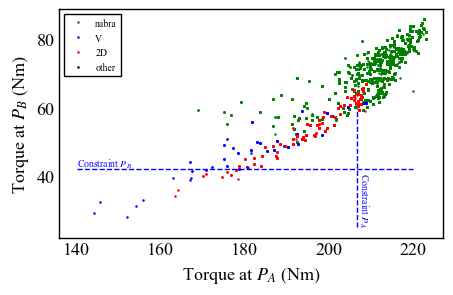

In [67]:
val = np.array(g_1)
val_2D = val[res_topology==3]
val_V = val[res_topology==1]
val_nabra = val[res_topology==2]
val_other = val[np.isnan(res_topology)]

# fig, ax = plt.subplots(figsize=(8/2.54,5/2.54))
fig, ax = plt.subplots(figsize=(12/2.54,8/2.54))

ax.plot(-val_nabra.T[0]*PA[0]+PA[0]*alpha,-val_nabra.T[1]*PA[0]+PB[0]*alpha, 'o', c='g', ms=0.8, label='nabra')
ax.plot(-val_V.T[0]*PA[0]+PA[0]*alpha,-val_V.T[1]*PA[0]+PB[0]*alpha, 'o', c='b', ms=0.8, label='V')
ax.plot(-val_2D.T[0]*PA[0]+PA[0]*alpha,-val_2D.T[1]*PA[0]+PB[0]*alpha, 'o', c='r', ms=0.8, label='2D')
ax.plot(-val_other.T[0]*PA[0]+PA[0]*alpha,-val_other.T[1]*PA[0]+PB[0]*alpha, 'o', c='k', ms=0.8, label='other')


ax.plot([140,220],[PB[0]*alpha,PB[0]*alpha],'b--', linewidth=1)
ax.plot([PA[0]*alpha,PA[0]*alpha],[25,60],'b--', linewidth=1)
# ax.plot((-np.array(g_1)[:,:,0]*PA[0]+PA[0]*alpha).flatten(),
#          (-np.array(g_1)[:,:,1]*PA[0]+PB[0]*alpha).flatten(),
#          'o', c='k', ms=1, label='All pop.')
# ax.plot(-np.array(g_1)[-1,:,0]*PA[0]+PA[0]*alpha,
#          -np.array(g_1)[-1,:,1]*PA[0]+PB[0]*alpha,
#          '^', c='r', ms=2, label='Last pop.')
# ax.plot(-np.array(g_1)[-1,15,0]*PA[0]+PA[0]*alpha,
#          -np.array(g_1)[-1,15,1]*PA[0]+PB[0]*alpha,
#          's', c='g', ms=5)

# pf_tmp = calc_pareto_front(np.array(f_1[-1]).reshape(s[1], s[2]))


# ax.set_yticks(np.arange(120,240+1,40))
# ax.set_yticklabels(np.arange(120,240+1,40))
# ax.set_ylim([120,240])
ax.set_xlabel('Torque at $\itP$$_A$ (Nm)')
ax.set_ylabel('Torque at $\itP$$_B$ (Nm)')

ax.text(140,40*1.07 ,'Constraint $\itP$$_B$',color='b', fontsize=7)
ax.text(197*1.05,26 ,'Constraint $\itP$$_A$',color='b', rotation=-90, fontsize=7)
# ax.text(10,205,'A',color='g')
# ax.text(13,222,'B',color='g')
# ax.text(16.5,227,'C',color='g')

ax.legend(loc='upper left',fontsize=7)

fig.tight_layout()
# plt.savefig(f'{date}_all_population_w_topology_condition1.png', dpi=300, format='png')



In [52]:
%timeit f.optimize(Ie_max='134', Vdc='650', torque1='197, 3000', torque2='40, 11000', efficiency1='20, 3500', efficiency2='20, 11000')

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |      100 |      5 |  0.000000E+00 |  0.1101702921 |             - |             -
     2 |      110 |      6 |  0.000000E+00 |  0.0853206418 |  0.0469490200 |         ideal
     3 |      120 |      5 |  0.000000E+00 |  0.0737424859 |  0.0179392211 |         ideal
     4 |      130 |      5 |  0.000000E+00 |  0.0634556303 |  0.000000E+00 |             f
     5 |      140 |      7 |  0.000000E+00 |  0.0548189966 |  0.0504765613 |             f
     6 |      150 |      8 |  0.000000E+00 |  0.0471052534 |  0.0001277132 |             f
     7 |      160 |      8 |  0.000000E+00 |  0.0407421803 |  0.0001277132 |             f
     8 |      170 |      8 |  0.000000E+00 |  0.0341295054 |  0.0001277132 |             f
     9 |      180 |      7 |  0.000000E+00 |  0.0293799618 |  0.0197244022 |         ideal
    10 |      190 |      7 |  0.000000E+00 |  0.0251837104 |  0.000000E+00 |             f

In [53]:
params_optimization['verbose'] = False
f = Optimize()
%timeit f.optimize(Ie_max='134', Vdc='650', torque1='197, 3000', torque2='40, 11000', efficiency1='20, 3500', efficiency2='20, 11000')

elapsed time: 418.13639068603516 sec
elapsed time: 419.5835599899292 sec
elapsed time: 419.91111516952515 sec
elapsed time: 416.2808358669281 sec
elapsed time: 415.35394763946533 sec
elapsed time: 415.7365629673004 sec
elapsed time: 417.7187645435333 sec
elapsed time: 418.85351181030273 sec
6min 57s ± 1.74 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


after FEA

In [37]:
# fname = "220706_poolformer_2DVNabla"
topols = ["2D", "V", "Nabla"]
# dt = 221205175204
n_gens = [99]
f_fea_all = []
for n_gen in n_gens:
    tmp0 = []
    tmp1 = []
    for topol in topols:
        try:
            tmp0.append(pd.read_csv(f'{save_dir}\\{dt}\\221205_fea_results_under_condition_{topol}_0.csv', index_col=0))
            tmp1.append(pd.read_csv(f'{save_dir}\\{dt}\\221205_fea_results_under_condition_{topol}_1.csv', index_col=0))
        except FileNotFoundError as e:
            print(e, topol, n_gen)
    tmp0_df = tmp0[0]
    tmp1_df = tmp1[0]
    n_topol = len(tmp0)
    if n_topol>1:
        for i in range(n_topol-1):
            tmp0_df[tmp0[i+1].notnull().all(axis=1)] = tmp0[i+1][tmp0[i+1].notnull().all(axis=1)]
            tmp1_df[tmp1[i+1].notnull().all(axis=1)] = tmp1[i+1][tmp1[i+1].notnull().all(axis=1)]
    f_fea_all.append([tmp0_df, tmp1_df])

gen: 99


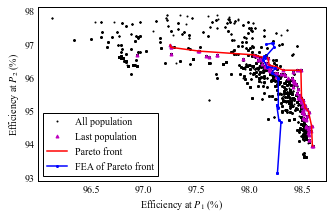

In [40]:

# n_gen = 99
# i = 2
# inds = [2,1,3,2,0]
n_gens = [99]
inds = [0]
for i, n_gen in enumerate(n_gens):
    print(f'gen: {n_gen}')
    # fig, ax = plt.subplots(figsize=(8/2.54,5/2.54))
    fig, ax = plt.subplots(figsize=(12/2.54,8/2.54))

    s = np.array(f_1[:n_gen+1]).shape
    pf_tmp = calc_pareto_front(np.array(f_1[n_gen]).reshape(s[1], s[2]))
    # ax.plot(pf_tmp[:,0]*14.63, pf_tmp[:,1]*-197, c='c', linewidth=1)
    # ax.plot([5,17],[197*1.03,197*1.03],'b--', linewidth=1)
    ax.plot(np.array(f_1[:n_gen+1]).reshape(s[0]*s[1], s[2])[:,0]*-100,
             np.array(f_1[:n_gen+1]).reshape(s[0]*s[1], s[2])[:,1]*-100,
             'o', c='k', ms=1, label='All population')    
    ax.plot(np.array(f_1[n_gen]).reshape(s[1], s[2])[:,0]*-100,
             np.array(f_1[n_gen]).reshape(s[1], s[2])[:,1]*-100,
             '^', c='m', ms=3, label='Last population')
    ax.plot(pf_tmp[inds[i]:][:,0]*-100,pf_tmp[inds[i]:][:,1]*-100,
             'r-',label='Pareto front')
#     ax.plot(pf_tmp[:,0]*-100,pf_tmp[:,1]*-100,
#              'r-',label='Last population')

    ax.plot(
        f_fea_all[i][0]['Efficiency (%)'].dropna(how='any'),
        f_fea_all[i][1]['Efficiency (%)'].dropna(how='any'),
        'bo-', label='FEA of Pareto front', ms=2
    )
    
#     df_tmp1 = f_fea_all[i][0][['Efficiency (%)']].copy()
#     df_tmp1['pf_pred'] = pf_tmp[:,0]*-100
#     df_tmp1 = df_tmp1[df_tmp1.notnull().all(axis=1)]
#     df_tmp2 = f_fea_all[i][1][['Efficiency (%)']].copy()
#     df_tmp2['pf_pred'] = pf_tmp[:,1]*-100
#     df_tmp2 = df_tmp2[df_tmp2.notnull().all(axis=1)]
    
#     for j in range(df_tmp1.shape[0]):
# #         ax.arrow(
#          ax.annotate(
#              " ",
#             (df_tmp1['pf_pred'].iloc[j], df_tmp2['pf_pred'].iloc[j]),
#             (df_tmp1['Efficiency (%)'].iloc[j], df_tmp2['Efficiency (%)'].iloc[j]),
# #             (df_tmp1['Efficiency (%)'].iloc[i]-df_tmp1['pf_pred'].iloc[i],
# #             df_tmp2['Efficiency (%)'].iloc[i]-df_tmp2['pf_pred'].iloc[i]), 
# #             width=0.1,
#             arrowprops=dict(arrowstyle='-|>', mutation_scale=5, color='gray')
#         )
    
    
    ax.set_xlabel('Efficiency at $\itP$$_1$ (%)')
    ax.set_ylabel('Efficiency at $\itP$$_2$ (%)')

    # ax.set_xlim([97.6,99])
#     ax.set_xlim([96.,100])
#     ax.set_ylim([94.,98])
    
    ax.legend(fontsize=10)
    fig.tight_layout()
#     plt.savefig(f'figure\\{date}_all_population_vs_FEA_gen{n_gen+1}.png', dpi=300, format='png')
    plt.show()
    
#     print(
#         (pf_tmp[:,0]*-100-f_fea_all[i][0]['Efficiency (%)']).median()
#     )
#     print(
#         (pf_tmp[:,1]*-100-f_fea_all[i][1]['Efficiency (%)']).median()
#     )

gen: 99


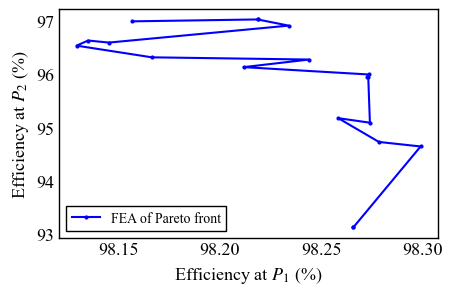

In [72]:

# n_gen = 99
# i = 2
# inds = [2,1,3,2,0]
n_gens = [99]
inds = [0]
for i, n_gen in enumerate(n_gens):
    print(f'gen: {n_gen}')
    # fig, ax = plt.subplots(figsize=(8/2.54,5/2.54))
    fig, ax = plt.subplots(figsize=(12/2.54,8/2.54))

    s = np.array(f_1[:n_gen+1]).shape
    pf_tmp = calc_pareto_front(np.array(f_1[n_gen]).reshape(s[1], s[2]))
    # ax.plot(pf_tmp[:,0]*14.63, pf_tmp[:,1]*-197, c='c', linewidth=1)
    # ax.plot([5,17],[197*1.03,197*1.03],'b--', linewidth=1)
    # ax.plot(np.array(f_1[:n_gen+1]).reshape(s[0]*s[1], s[2])[:,0]*-100,
    #          np.array(f_1[:n_gen+1]).reshape(s[0]*s[1], s[2])[:,1]*-100,
    #          'o', c='k', ms=1, label='All population')    
    # ax.plot(np.array(f_1[n_gen]).reshape(s[1], s[2])[:,0]*-100,
    #          np.array(f_1[n_gen]).reshape(s[1], s[2])[:,1]*-100,
    #          '^', c='m', ms=3, label='Last population')
    # ax.plot(pf_tmp[inds[i]:][:,0]*-100,pf_tmp[inds[i]:][:,1]*-100,
    #          'r-',label='Pareto front')
#     ax.plot(pf_tmp[:,0]*-100,pf_tmp[:,1]*-100,
#              'r-',label='Last population')

    ax.plot(
        f_fea_all[i][0]['Efficiency (%)'].dropna(how='any'),
        f_fea_all[i][1]['Efficiency (%)'].dropna(how='any'),
        'bo-', label='FEA of Pareto front', ms=2
    )
    # print(
    #     f_fea_all[i][0]['Efficiency (%)'].dropna(how='any'),
    #     f_fea_all[i][1]['Efficiency (%)'].dropna(how='any'),
    # )
    
#     df_tmp1 = f_fea_all[i][0][['Efficiency (%)']].copy()
#     df_tmp1['pf_pred'] = pf_tmp[:,0]*-100
#     df_tmp1 = df_tmp1[df_tmp1.notnull().all(axis=1)]
#     df_tmp2 = f_fea_all[i][1][['Efficiency (%)']].copy()
#     df_tmp2['pf_pred'] = pf_tmp[:,1]*-100
#     df_tmp2 = df_tmp2[df_tmp2.notnull().all(axis=1)]
    
#     for j in range(df_tmp1.shape[0]):
# #         ax.arrow(
#          ax.annotate(
#              " ",
#             (df_tmp1['pf_pred'].iloc[j], df_tmp2['pf_pred'].iloc[j]),
#             (df_tmp1['Efficiency (%)'].iloc[j], df_tmp2['Efficiency (%)'].iloc[j]),
# #             (df_tmp1['Efficiency (%)'].iloc[i]-df_tmp1['pf_pred'].iloc[i],
# #             df_tmp2['Efficiency (%)'].iloc[i]-df_tmp2['pf_pred'].iloc[i]), 
# #             width=0.1,
#             arrowprops=dict(arrowstyle='-|>', mutation_scale=5, color='gray')
#         )
    
    
    ax.set_xlabel('Efficiency at $\itP$$_1$ (%)')
    ax.set_ylabel('Efficiency at $\itP$$_2$ (%)')

    # ax.set_xlim([97.6,99])
#     ax.set_xlim([96.,100])
#     ax.set_ylim([94.,98])
    
    ax.legend(fontsize=10)
    fig.tight_layout()
    # plt.savefig(f'figure\\{date}_all_population_vs_FEA_gen{n_gen+1}.png', dpi=300, format='png')
    plt.show()
    
#     print(
#         (pf_tmp[:,0]*-100-f_fea_all[i][0]['Efficiency (%)']).median()
#     )
#     print(
#         (pf_tmp[:,1]*-100-f_fea_all[i][1]['Efficiency (%)']).median()
#     )

In [35]:
f_fea_all[0][0]

NameError: name 'f_fea_all' is not defined

In [63]:
f_fea_all[0][1]

,Ia (A),beta (deg),N (min-1),Tavg (Nm),P (kW),Wi (W),Wc (W),Efficiency (%)
0,21.594808,15.2,3500.0,NaN,NaN,NaN,59.924143,NaN
1,21.594808,15.2,3500.0,NaN,NaN,NaN,59.924143,NaN
2,22.094808,15.4,3500.0,NaN,NaN,NaN,62.731201,NaN
3,22.594808,16.7,3500.0,NaN,NaN,NaN,65.602509,NaN
4,23.094808,17.2,3500.0,NaN,NaN,NaN,68.538066,NaN
5,22.594808,17.1,3500.0,NaN,NaN,NaN,65.602509,NaN
6,22.594808,17.1,3500.0,NaN,NaN,NaN,65.602509,NaN
7,23.094808,17.3,3500.0,NaN,NaN,NaN,68.538066,NaN
8,23.094808,17.5,3500.0,NaN,NaN,NaN,68.538066,NaN
9,23.594808,18.2,3500.0,21.283458,7.800795,64.400094,71.537874,98.273219


In [13]:
interact_manual(
    f.optimize, Ie_max='134', Vdc='650', 
    torque1='197, 3000', torque2='40, 11000', 
    efficiency1='30, 3500', efficiency2='30, 11000'
);

interactive(children=(Text(value='134', description='Ie_max'), Text(value='650', description='Vdc'), Text(valu…

In [14]:
interactive_plot = interactive(
    f.opt.show_different_result, 
    {'manual': True},
    Iem=(Iem_min, Iem_max, Iem_interval), 
    Vdc=(Vdc_min, Vdc_max, Vdc_interval),
    gain1 = (-200., 200., 10.),
    gain2 = (-200., 200., 10.),
    gain3 = (-200., 200., 10.),
)
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(FloatSlider(value=134.0, description='Iem', max=150.0, step=5.0), FloatSlider(value=650.…